# Libs and loading moon img

In [ ]:
from matplotlib.pyplot import plot,imshow,figure,subplot,cm
from skimage import io,transform,exposure,feature,morphology,filters
from skimage.filters import threshold_otsu
import numpy as np
from skimage.morphology import selem
from skimage.filters import edges
from skimage.draw import circle
from skimage.color import gray2rgb
import time

In [ ]:
#TODO: recalculate position to big MOON picture

In [ ]:
img_big = io.imread("./drive/MyDrive/mesiac.tif")

# Testing algorithm

Calculating HoughT
Looking for big crater...
Processing peaks...
Got: 1167 peaks
Removing dulicates..
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
FIND one! with radius:410
Looking for small craters...
Processing peaks...
Got: 3039 peaks
Removing dulicates..
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
gotthem!10
(array([610, 707, 677, 701, 568, 770, 930, 592, 884, 880]), array([ 664,  924,  642,  722,  808,  901,  957,  902, 1049,  798]), array([10, 10,  7,  7,  7,  7,  7,  6,  7,  6]))


True

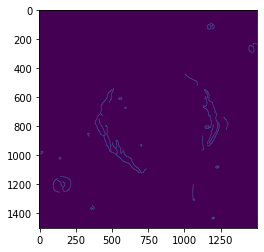

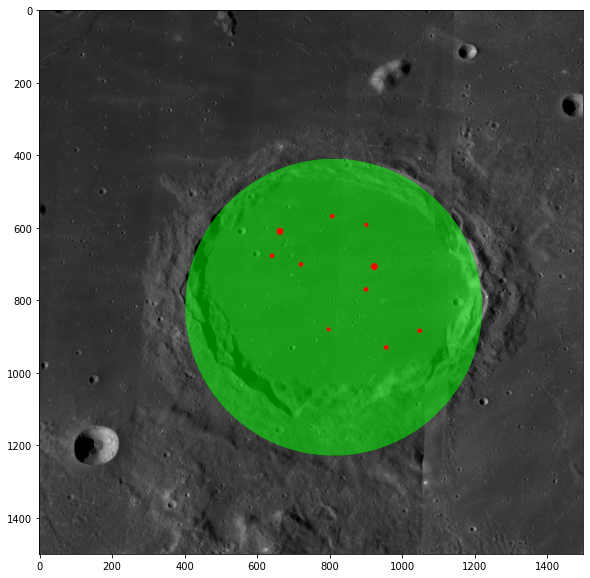

In [ ]:
cut_img = img_big[8000:9500,15500:17000]
cut_img = processCutImage(cut_img)
imshow(cut_img)
algorithm(img_canny,img)

In [ ]:
a = [1,2,34]
for i,x in enumerate(a):
    print(x)

1
2
34


In [ ]:
picGen = cutBig_image(img_big,2000,1000)
for img,pos in picGen:
    img_canny = feature.canny(img, sigma=4, low_threshold=15, high_threshold=70)
    if algorith(img_canny,img):
        break;


In [ ]:
import math
def cutBig_image(img_big,cut_h,cut_w):
    x,y = 0,0

    h,w = img_big.shape
    stopIterate = math.ceil(h/cut_h)*math.ceil(w/cut_w)
    iterationNum = 0
    while(1):
        
        iterationNum = iterationNum +1
        if iterationNum > stopIterate:
            break;
        elif x>w:
            x-=cut_w #vrat sa s5
            cutImg = img_big[y:(y+cut_h),x:-1]
            y+=cut_h
            x = 0
        elif x>w and y>h:
             y-=cut_h
             x-=cut_w
             cutImg = img_big[y:-1,x:-1]
        elif y>h:
             y-=cut_h
             cutImg = img_big[y:-1,x:(x+cut_w)]
        else:
            cutImg = img_big[y:(y+cut_h),x:(x+cut_w)]
        x += cut_w

        if (cutImg[0,0]+cutImg[-1,0]+cutImg[0,-1]+cutImg[-1,-1])!= 0:
            print("Iteration num: {}/{}".format(iterationNum,stopIterate))
            yield cutImg,(y,x)
        else:
            print("Skipping Black Picture,Iteration num: {}/{}".format(iterationNum,stopIterate))

# Algorithm

In [ ]:
def algorithm(img_mask,or_img):
    res = getBigCrater(img_mask,or_img,np.arange(400, 500, 10))
    if res == None:
        return False
    else :
        BC_img,BC_img_pos,BC_circle,mask = res
        BC_img = processBigCrater(BC_img,mask)
        SM_circles = findSmallCraters_inBIG_CRATER(BC_img,np.arange(5, 12, 1),(BC_img_pos[0],BC_img_pos[1]))

        print(SM_circles)
        plotCrater(or_img,BC_circle,SM_circles)
        return True
    
   


## Processing images and help functions

In [ ]:
def processBigCrater(BC_img,mask):

    #old
    BC_img_new = feature.canny(BC_img, sigma=2, low_threshold=40, high_threshold=60)
    BC_img_new = morphology.dilation(BC_img_new,morphology.selem.diamond(5))
    BC_img_new[mask] = 0

    return BC_img_new

In [ ]:
def processCutImage(cut_img):
    cut_img = feature.canny(cut_img, sigma=4, low_threshold=15, high_threshold=50)
    return cut_img

In [ ]:

def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    
    if iteration == total: 
        print()

In [ ]:
def plotCrater(img,BC_circle,SM_circles):
    Craters_RGBA_mask = prepareRGBA_mask(img)

    circy_BIG, circxBIG = circle(BC_circle[1], BC_circle[0], BC_circle[2],shape=img.shape)

    Craters_RGBA_mask[circy_BIG,circxBIG] = (0,1,0,0.5)
    
    for center_y, center_x, radius in zip(SM_circles[0],SM_circles[1],SM_circles[2]): 
        circy, circx = circle(center_y, center_x, radius,shape=img.shape)
        Craters_RGBA_mask[circy,circx] = (1,0,0,1)

    figure(figsize=(20,10))
    imshow(img,cmap="gray")
    imshow(Craters_RGBA_mask,cmap="gray")

def prepareRGBA_mask(image):
    img1 = np.zeros(image.shape)
    img1 = gray2rgb(img1)
    img1 = np.concatenate((img1, np.zeros((img1.shape[1], img1.shape[0], 1))), axis=2)
    return img1


## SmallCrater

In [ ]:
def findSmallCraters_inBIG_CRATER(image,hough_radii,ImgPos):
    hough_res = gen_houghSpace_circle(image,hough_radii)
    print("Looking for small craters...")
    cx, cy, radii = findPeaks(hough_res,hough_radii,num_peaks=10,threshold=0.5,min_pixel_distance=60)
    
    print("gotthem!{}".format(len(cx)))
    for i in range(0,len(cx)):
        cy[i],cx[i] = smallInBigPosition(ImgPos,cy[i],cx[i])
    return cy, cx, radii


In [ ]:
def smallInBigPosition(smallImgPos,y_prev,x_prev):
    y_s,x_s = smallImgPos
    return (y_prev+y_s,x_prev+x_s)

## getBigCrater

In [ ]:
def getBigCrater(masked_img,from_img,hough_radii):
    print("Calculating HoughT")
    #hough_res = transform.hough_circle(masked_img, hough_radii)
    hough_res = gen_houghSpace_circle(img_canny,hough_radii)
    # Select the most prominent 3 circles
    print("Looking for big crater...")
    threshPeaks = 0.5*np.max(hough_res);
    cx, cy, radii = findPeaks(hough_res,hough_radii)
    

    if (len(cx) == 0):
        print("There is not Big crater")
        return None    
    x = cx[0]
    y = cy[0]
    w = radii[0]
    radius = w
    print("FIND one! with radius:{}".format(radius))
    x_slice = slice(x-w,x+w)
    y_slice = slice(y-w,y+w)
    new_img = np.zeros((w*2,w*2))
    new_img = np.copy(from_img[y_slice,x_slice])

    mask = np.ones(new_img.shape,np.bool)

    radius = radius*0.65
    circy_n, circx_n = circle(w, w, radius,shape=new_img.shape)
    mask[circy_n,circx_n] = 0
    #new_img[mask] = 0 
    cir = (x, y, w)
    ImPos = (y-w,x-w)

    return (new_img,ImPos,cir,mask)


# Hough Elipse transform

## hough circle transform  in Cython

In [ ]:
%%writefile myLib.pyx
from skimage.draw import circle_perimeter
import numpy as np
cimport numpy as cnp

def gen_houghSpace_circle(cnp.ndarray img, cnp.ndarray[ndim=1, dtype=cnp.intp_t] radius):
    if img.ndim != 2:
        raise ValueError('The input image must be 2D.')

    xmax = img.shape[0]
    ymax = img.shape[1]

    # compute the nonzero indexes
    cdef cnp.ndarray[ndim=1, dtype=cnp.intp_t] x, y
    x, y = np.nonzero(img)
    cdef Py_ssize_t num_pixels = x.size


    cdef Py_ssize_t i, p, c, num_circle_pixels, tx, ty
    cdef double incr
    cdef cnp.ndarray[ndim=1, dtype=cnp.intp_t] circle_x, circle_y


    cdef cnp.ndarray[ndim=3, dtype=cnp.double_t] acc = \
         np.zeros((radius.size,
                   img.shape[0], 
                   img.shape[1]), dtype=np.double)
         

    for i, rad in enumerate(radius):
        # Store in memory the circle of given radius
        # centered at (0,0)
        circle_x, circle_y = circle_perimeter(0, 0, rad)

        num_circle_pixels = circle_x.size

        for p in range(num_pixels):
                # Plug the circle at (px, py),
                # its coordinates are (tx, ty)
            for c in range(num_circle_pixels):
                tx = circle_x[c] + x[p]
                ty = circle_y[c] + y[p]
                if 0 <= tx < xmax and 0 <= ty < ymax:
                    acc[i, tx, ty] += 1

    return acc

Overwriting myLib.pyx


### Compiling Cython

In [ ]:
%%writefile setup.py
from distutils.core import setup, Extension
from Cython.Build import cythonize
import numpy

setup(
    ext_modules=cythonize("myLib.pyx"),
    include_dirs=[numpy.get_include()]
)

In [ ]:
!python setup.py build_ext --inplace

In [ ]:
from myLib import gen_houghSpace_circle

# hough circle transform  in Python

In [ ]:
from skimage.draw import circle_perimeter
import numpy as np

def gen_houghSpace_circle(img,radius):
    if img.ndim != 2:
        raise ValueError('The input image must be 2D.')

    xmax = img.shape[0]
    ymax = img.shape[1]

    # compute the nonzero indexes
    x, y = np.nonzero(img)
    num_pixels = len(x)


    i, p, c, num_circle_pixels, tx, ty =  0, 0, 0, 0, 0, 0
    incr = 0
    circle_x, circle_y= 0,0


    acc = np.zeros((len(radius),img.shape[0], img.shape[1]), dtype=np.double)
    
    IterationCounter = 0
    print(radius)
    for i, rad in enumerate(radius):
        IterationCounter+=1
        print("Step: {}/{}".format(IterationCounter,len(radius)))
        # Store in memory the circle of given radius
        # centered at (0,0)
        circle_x, circle_y = circle_perimeter(0, 0, rad)

        num_circle_pixels = circle_x.size

        for p in range(num_pixels):
            print("Step: {}/{}".format(p,num_pixels)))
                # Plug the circle at (px, py),
                # its coordinates are (tx, ty)
            for c in range(num_circle_pixels):
                tx = circle_x[c] + x[p]
                ty = circle_y[c] + y[p]
                if 0 <= tx < xmax and 0 <= ty < ymax:
                    acc[i, tx, ty] += 1

    return acc

## findPeaks

In [ ]:
def findPeaks(hough_space,rad_range,threshold=None,min_pixel_distance = 5,num_peaks = 1):
    print("Processing peaks...")
    if threshold == None:
        bin_threshold= 0.5*(np.max(hough_space)/360)
    else:
        bin_threshold = threshold*(np.max(hough_space)/360)

    out_circles = []
    ac_r,ac_x,ac_y = hough_space.shape
    for x in range(ac_x):
        for y in range(ac_y):
            for r in range(ac_r):
                current_vote_percentage = hough_space[r,x,y]/360
                if current_vote_percentage >= bin_threshold:
                    out_circles.append((x, y, rad_range[r],current_vote_percentage))
    out_circles = sort_list_last(out_circles)
    postprocess_circles = []
    peaksLenght = len(out_circles)
    print("Got: {} peaks".format(peaksLenght))
    print("Removing dulicates..")
    i = 0
    for x, y, r,v in out_circles:
      i+=1
      printProgressBar(i,peaksLenght)
      # Exclude circles that are too close of each other
      # all((x - xc) ** 2 + (y - yc) ** 2 > rc ** 2 for xc, yc, rc, v in postprocess_circles)
      # Remove nearby duplicate circles based on pixel_threshold
      if all(abs(x - xc) > min_pixel_distance or abs(y - yc) > min_pixel_distance or abs(r - rc) > min_pixel_distance for xc, yc, rc,v in postprocess_circles):
        postprocess_circles.append((x, y, r,v))
    return procesPeaks(postprocess_circles[0:num_peaks])

def last(n): return n[-1]

def sort_list_last(tuples):
    return sorted(tuples, key=last,reverse=True)

def procesPeaks(peaks):
    peakslen = len(peaks)
    cx = np.zeros(peakslen,dtype=np.int)
    cy = np.zeros(peakslen,dtype=np.int)
    radius = np.zeros(peakslen,dtype=np.int)
    for i in range(0,peakslen):
        cx[i],cy[i],radius[i],_ = peaks[i]

    return (cx,cy,radius)